<a href="https://colab.research.google.com/github/s56roy/Fake-News-Classification/blob/main/Classical_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing ml libraries
import numpy as np
import pandas as pd
import torch

In [ ]:
!pip install datasets

In [3]:
from torch.utils.data import Dataset
from torchvision import datasets
from datasets import load_dataset

In [4]:
# download dataset
dataset = load_dataset("datacommons_factcheck", "fctchk_politifact_wapo")

Reusing dataset datacommons_factcheck (/root/.cache/huggingface/datasets/datacommons_factcheck/fctchk_politifact_wapo/1.0.0/e3861c84c3e449fb0c316b75997e30bbf723e2ca7f33c668bda07b7436567b35)


In [5]:
# convert the dataset into pandas data frame for easy manipulation
pd_data = pd.DataFrame(dataset['train'])

In [6]:
pd_data

,claim_author_name,claim_date,claim_text,review_date,review_rating,review_url,reviewer_name
0,Facebook posts,2019-01-01,"Quotes Michelle Obama as saying, ""White folks ...",2019-01-03,Pants on Fire,https://www.politifact.com/facebook-fact-check...,PolitiFact
1,Ted Cruz,2018-04-11,"Says Facebook shut down a ""Chick-Fil-A Appreci...",2018-04-23,Half True,https://www.politifact.com/texas/statements/20...,PolitiFact
2,Donald Trump,2018-06-12,"""We haven’t given up anything other than … I a...",2018-06-12,Will military drills end?,http://www.politifact.com/truth-o-meter/articl...,PolitiFact
3,Various websites,2017-09-03,"""BREAKING: 2 Democrat Congressmen On ISIS Payr...",2017-10-26,False,https://www.factcheck.org/2017/10/no-isis-arre...,FactCheck.org
4,James Woods,2016-08-27,"The ""Dallas Cowboys can’t put a sticker on the...",2016-09-01,True,https://www.politifact.com/texas/statements/20...,PolitiFact
...,...,...,...,...,...,...,...
5627,Wisconsin Republican Party,,Claims that Democratic candidate for governor ...,2018-08-10,Half True,https://www.politifact.com/wisconsin/statement...,PolitiFact
5628,Various websites,2018-05-01,"""Clint Eastwood Leaves His Estate To The Trump...",2018-05-08,False,https://www.factcheck.org/2018/05/eastwood-not...,FactCheck.org
5629,Donald Trump,2017-11-27,"""You were here long before any of us were here...",2017-11-27,Needs Context,https://www.washingtonpost.com/news/fact-check...,Washington Post
5630,Mick Mulvaney,2019-01-06,"""We had arrested 17,000 criminals at the south...",2019-01-08,Misleading,https://www.factcheck.org/2019/01/misleading-b...,FactCheck.org


Dropping any row with NaN values

---



In [7]:
# drop `NaN` rows
pd_data = pd_data.dropna(axis=0)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt


In [9]:
value_counts=pd_data['review_rating'].value_counts(normalize=True)*100

It is observed that there is no row that has been dropped due to NaN values

---



In [10]:
pd_data['review_rating'].describe()

count      5632
unique      391
top       False
freq       1304
Name: review_rating, dtype: object

In [11]:
# Select the values where the count is less than 5
to_remove = value_counts[value_counts <= 5].index

In [12]:
# Keep rows where the city column is not in to_remove
df = pd_data[~pd_data.review_rating.isin(to_remove)]
df

,claim_author_name,claim_date,claim_text,review_date,review_rating,review_url,reviewer_name
0,Facebook posts,2019-01-01,"Quotes Michelle Obama as saying, ""White folks ...",2019-01-03,Pants on Fire,https://www.politifact.com/facebook-fact-check...,PolitiFact
1,Ted Cruz,2018-04-11,"Says Facebook shut down a ""Chick-Fil-A Appreci...",2018-04-23,Half True,https://www.politifact.com/texas/statements/20...,PolitiFact
3,Various websites,2017-09-03,"""BREAKING: 2 Democrat Congressmen On ISIS Payr...",2017-10-26,False,https://www.factcheck.org/2017/10/no-isis-arre...,FactCheck.org
4,James Woods,2016-08-27,"The ""Dallas Cowboys can’t put a sticker on the...",2016-09-01,True,https://www.politifact.com/texas/statements/20...,PolitiFact
5,National Republican Congressional Committee,2016-08-10,"Tom Suozzi raised taxes ""by hundreds of millio...",2016-09-23,True,https://www.politifact.com/new-york/statements...,PolitiFact
...,...,...,...,...,...,...,...
5624,Newt Gingrich,2011-06-15,Every 10th dollar spent by the Social Security...,2016-07-15,Mostly True,https://www.politifact.com/georgia/statements/...,PolitiFact
5626,Scott Walker,2017-07-19,"""We took Wisconsin from the Bottom 10 for busi...",2017-08-23,Mostly False,https://www.politifact.com/wisconsin/statement...,PolitiFact
5627,Wisconsin Republican Party,,Claims that Democratic candidate for governor ...,2018-08-10,Half True,https://www.politifact.com/wisconsin/statement...,PolitiFact
5628,Various websites,2018-05-01,"""Clint Eastwood Leaves His Estate To The Trump...",2018-05-08,False,https://www.factcheck.org/2018/05/eastwood-not...,FactCheck.org


The number of classes after removing the rare occuring classes


*   original number of classes: 391
*   Updated number of classes: 6



---



In [13]:
#Chceking
df['review_rating'].value_counts(normalize=True)*100
#The new data has only 6 features ( with the others dropped the fequencies has increased)

False            30.878522
Mostly False     15.889178
Pants on Fire    15.770779
Half True        15.273502
Mostly True      14.065830
True              8.122188
Name: review_rating, dtype: float64

**Convert 6 Class to 2 class Problem**



*   'True', 'Mostly True', 'Half True' are converted to label - True
*   'False', 'Mostly False', 'Pants on Fire' are converted to label - Fake





---




In [14]:
# create a new column: 'category' for binary classification
df['category'] = df['review_rating'].apply(lambda x: 'True' if x in ['True', 'Mostly True', 'Half True'] else 'Fake')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Concatination Of Features**

*   Claim text is concatinated with "claim_author_name" and "reviewer_name".
*   This is done so that both "claim_author_name" and "reviewer_name" can also be used as features


---




In [15]:

# create a new column: 'claim' by merging 3 columns
df['claim'] = df['claim_author_name'] + [' '] * len(df) + df['claim_text'] + [' '] * len(df) + df['reviewer_name']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
df['review_url'][1]

'https://www.politifact.com/texas/statements/2018/apr/23/ted-cruz/ted-cruz-correct-facebook-shut-down-chick-fil-appr/'

In [16]:
df

,claim_author_name,claim_date,claim_text,review_date,review_rating,review_url,reviewer_name,category,claim
0,Facebook posts,2019-01-01,"Quotes Michelle Obama as saying, ""White folks ...",2019-01-03,Pants on Fire,https://www.politifact.com/facebook-fact-check...,PolitiFact,Fake,Facebook posts Quotes Michelle Obama as saying...
1,Ted Cruz,2018-04-11,"Says Facebook shut down a ""Chick-Fil-A Appreci...",2018-04-23,Half True,https://www.politifact.com/texas/statements/20...,PolitiFact,True,"Ted Cruz Says Facebook shut down a ""Chick-Fil-..."
3,Various websites,2017-09-03,"""BREAKING: 2 Democrat Congressmen On ISIS Payr...",2017-10-26,False,https://www.factcheck.org/2017/10/no-isis-arre...,FactCheck.org,Fake,"Various websites ""BREAKING: 2 Democrat Congres..."
4,James Woods,2016-08-27,"The ""Dallas Cowboys can’t put a sticker on the...",2016-09-01,True,https://www.politifact.com/texas/statements/20...,PolitiFact,True,"James Woods The ""Dallas Cowboys can’t put a st..."
5,National Republican Congressional Committee,2016-08-10,"Tom Suozzi raised taxes ""by hundreds of millio...",2016-09-23,True,https://www.politifact.com/new-york/statements...,PolitiFact,True,National Republican Congressional Committee To...
...,...,...,...,...,...,...,...,...,...
5624,Newt Gingrich,2011-06-15,Every 10th dollar spent by the Social Security...,2016-07-15,Mostly True,https://www.politifact.com/georgia/statements/...,PolitiFact,True,Newt Gingrich Every 10th dollar spent by the S...
5626,Scott Walker,2017-07-19,"""We took Wisconsin from the Bottom 10 for busi...",2017-08-23,Mostly False,https://www.politifact.com/wisconsin/statement...,PolitiFact,Fake,"Scott Walker ""We took Wisconsin from the Botto..."
5627,Wisconsin Republican Party,,Claims that Democratic candidate for governor ...,2018-08-10,Half True,https://www.politifact.com/wisconsin/statement...,PolitiFact,True,Wisconsin Republican Party Claims that Democra...
5628,Various websites,2018-05-01,"""Clint Eastwood Leaves His Estate To The Trump...",2018-05-08,False,https://www.factcheck.org/2018/05/eastwood-not...,FactCheck.org,Fake,"Various websites ""Clint Eastwood Leaves His Es..."


In [17]:
# finalized data
final_data = df[['claim', 'category']]

**Observations :-**

*   Complete set of data contain 800 rows.
*   The dataset has been converted to binary class - "True" or "Fake"

### General Data Preprocessing

In this section, we are cleaning the text with removing any kind of non alphanumeric characters as well as converting to all lower case from the claim column text.



In [18]:
import re
def clean_txt(text):
    text = re.sub("'", "", text)
    text = re.sub("(\\W)+", " ", text)
    text = text.lower()
    return text

final_data['claim'] = final_data['claim'].apply(clean_txt)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
final_data

,claim,category
0,facebook posts quotes michelle obama as saying...,Fake
1,ted cruz says facebook shut down a chick fil a...,True
3,various websites breaking 2 democrat congressm...,Fake
4,james woods the dallas cowboys can t put a sti...,True
5,national republican congressional committee to...,True
...,...,...
5624,newt gingrich every 10th dollar spent by the s...,True
5626,scott walker we took wisconsin from the bottom...,Fake
5627,wisconsin republican party claims that democra...,True
5628,various websites clint eastwood leaves his est...,Fake


### Plotting Data

#### Word Count histogram

We use final_data set to perform exploratory analysis. First we want to look at the word count for each news category and see if there is difference between real and fake news.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


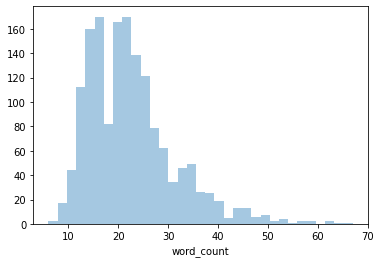

In [20]:
final_data['word_count'] = [len(s.split()) for s in final_data['claim']]
#real 
sns.distplot(final_data['word_count'][final_data['category'] == 'True'], kde=False, rug=False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


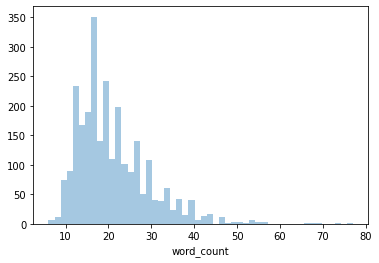

In [21]:
sns.distplot(final_data['word_count'][(final_data['category'] == 'Fake') & (final_data['word_count'] < 20000)], kde=False, rug=False)

Observations:


*   From the above bar graphs, it is evident that Fake news text is more sparse compared to True news. That means it tries to mimic the True news with same number of words.


---





/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'label')

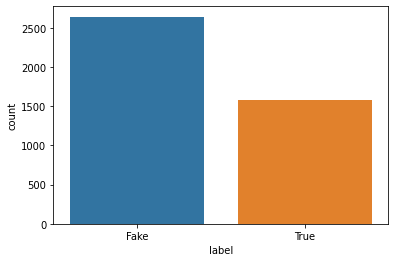

In [22]:
sns.countplot(final_data.category)
plt.xlabel('label')



*   True news are one-fourth of the Fake news data points
*   This shows the data is imbalanced



#### Word Cloud

Next we like to see what are the most common words in real/fake news to discover some patterns. Word cloud is a popular way to visualize it.

In [23]:
from wordcloud import WordCloud

def plot_wordcloud(target,width = 800, height = 400):
    """
    Plot wordcloud of real/fake news
    
    target: real/fake
    width: the width of plotted figure
    height: the height of plotted figure
    """
    if target == 1:
        t = 'Fake'
    elif target == 0:
        t = 'True'
    text = ''
    for t in final_data['claim'][final_data['category'] == t]:
        text = text + t
    wordcloud = WordCloud(max_font_size=40, min_font_size=20, width=800, height = 400, random_state=0).generate(text)
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

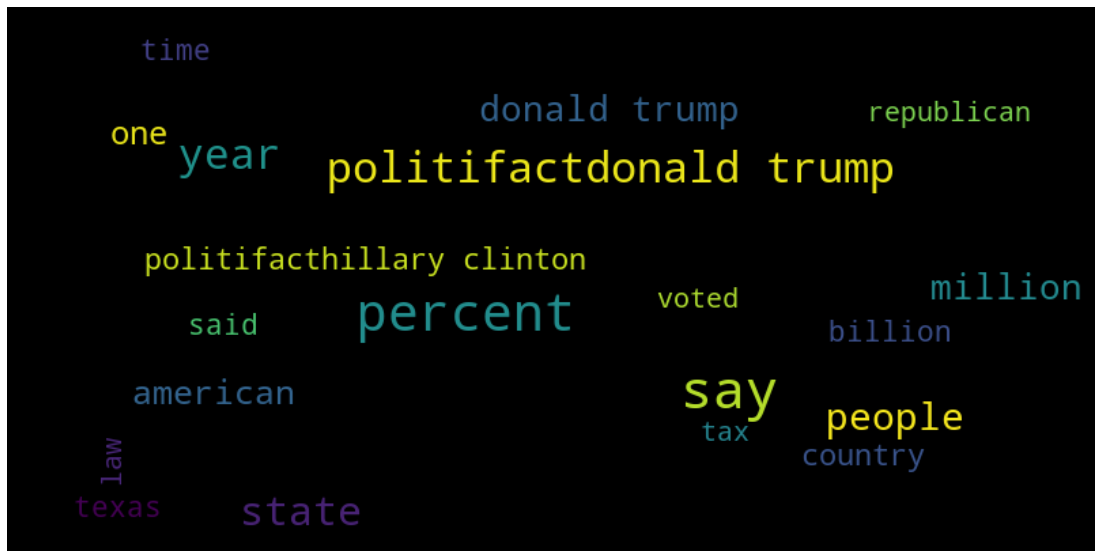

In [24]:
plot_wordcloud(0,width = 800, height = 400)

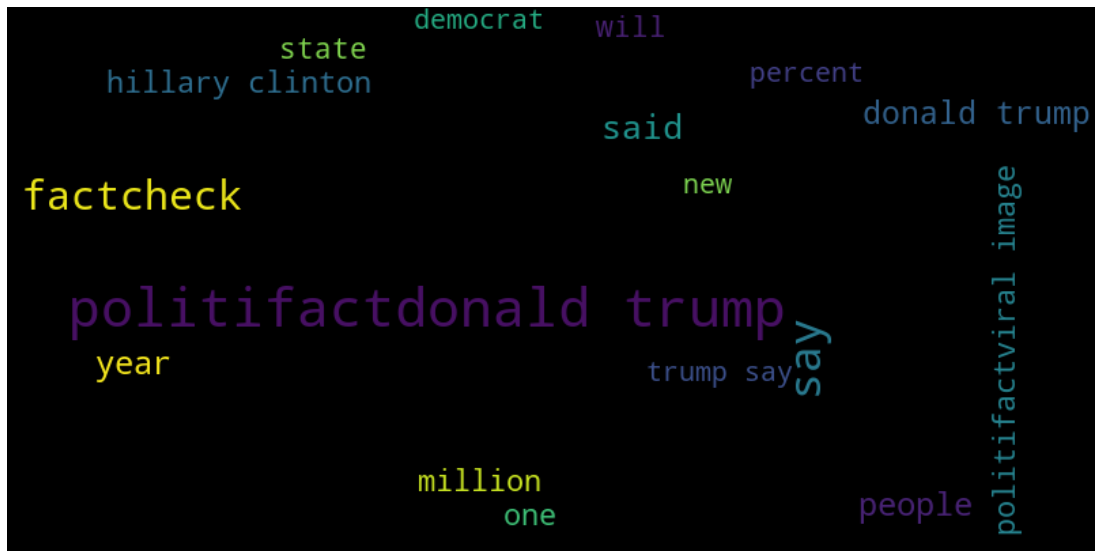

In [25]:
plot_wordcloud(1,width = 800, height = 400)

In [26]:
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE CLAIM
final_data['length'] = final_data['claim'].apply(len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


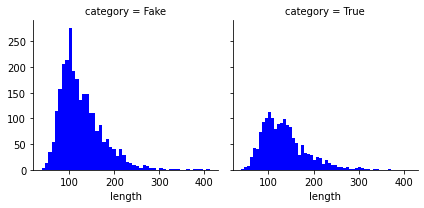

In [27]:
# COMPARING TEXT LENGTH TO Category/class
graph = sns.FacetGrid(data=final_data,col='category')
graph.map(plt.hist,'length',bins=50,color='blue')

In [28]:
final_data

,claim,category,word_count,length
0,facebook posts quotes michelle obama as saying...,Fake,16,99
1,ted cruz says facebook shut down a chick fil a...,True,13,74
3,various websites breaking 2 democrat congressm...,Fake,14,99
4,james woods the dallas cowboys can t put a sti...,True,22,120
5,national republican congressional committee to...,True,19,140
...,...,...,...,...
5624,newt gingrich every 10th dollar spent by the s...,True,39,222
5626,scott walker we took wisconsin from the bottom...,Fake,16,87
5627,wisconsin republican party claims that democra...,True,29,183
5628,various websites clint eastwood leaves his est...,Fake,14,90


In [29]:
final_data['category'] = final_data['category'].map(
                   {'True':1 ,'Fake':0})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
final_data

,claim,category,word_count,length
0,facebook posts quotes michelle obama as saying...,0,16,99
1,ted cruz says facebook shut down a chick fil a...,1,13,74
3,various websites breaking 2 democrat congressm...,0,14,99
4,james woods the dallas cowboys can t put a sti...,1,22,120
5,national republican congressional committee to...,1,19,140
...,...,...,...,...
5624,newt gingrich every 10th dollar spent by the s...,1,39,222
5626,scott walker we took wisconsin from the bottom...,0,16,87
5627,wisconsin republican party claims that democra...,1,29,183
5628,various websites clint eastwood leaves his est...,0,14,90


In [32]:
# split the dataset into train and test dataset by the ratio of 0.2
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(
    final_data['claim'],
    final_data['category'], 
    stratify= final_data['category'],
    test_size=0.2, random_state=42
)

**Count Vectorizer**

*CountVectorizer is used to convert a collection of text documents to a vector of term/token counts. It also enables the ​pre-processing of text data prior to generating the vector representation. This functionality makes it a highly flexible feature representation module for text.*

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english') 
# Fit and transform the training data.
count_train = count_vectorizer.fit_transform(x_train)
# Transform the test set 
count_test = count_vectorizer.transform(x_test)

**Tf-IDF Vectorizer**
*TF-IDF is an abbreviation for Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction*

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
#Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
#Transform the test set 
tfidf_test = tfidf_vectorizer.transform(x_test)

**XGBoost Classifier**

In [58]:
# XGBoost Classifier
import xgboost
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve



# XGBoost Classifier
import xgboost
from xgboost import XGBClassifier


xgb = XGBClassifier(colsample_bytree=1,gamma=0.5,max_depth= 3,
                    min_child_weight= 3,subsample=1, 
                    n_estimators=100,nthread=1)

params = {'min_child_weight': [1,3],
        'gamma': [0.5, 1, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.5,1],
        'max_depth': [3,6,9]}

model1 = GridSearchCV(xgb, param_grid=params, n_jobs=-1,cv=5,iid=False)

model1.fit(count_train,y_train)


#The best hyper parameters is set
print("Best Hyper Parameters for XGBoost:",model1.best_params_)
print("Best Parameters Score:\n",model1.best_score_)
predxgb = model1.predict(count_test)
#Prediction
print("Confusion Matrix for XGBoost Classifier:")
print(confusion_matrix(y_test,predxgb))
print("Accuracy: ",round(accuracy_score(y_test,predxgb)*100,2))
print("---------------------------------------------------------")
print("Classification Report:")
print(classification_report(y_test,predxgb))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Best Hyper Parameters for XGBoost: {'colsample_bytree': 1, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.6}
Best Parameters Score:
 0.6909406092483016
Confusion Matrix for XGBoost Classifier:
[[449  79]
 [176 141]]
Accuracy:  69.82
---------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       528
           1       0.64      0.44      0.53       317

    accuracy                           0.70       845
   macro avg       0.68      0.65      0.65       845
weighted avg       0.69      0.70      0.68       845



In [47]:
from sklearn.ensemble import VotingClassifier
# Random Forest
from sklearn.ensemble import RandomForestClassifier
#rmfr = RandomForestClassifier(random_state=56)
rmfr = RandomForestClassifier(criterion= 'gini', max_depth= None,
                              min_samples_leaf= 3, min_samples_split=2,
                              n_estimators= 100,n_jobs=-1, random_state=56)


ens = VotingClassifier(estimators=[('nb',nb_classifier), ('rf',rmfr), ('gb',xgb)], voting='soft')
# perceptron
ens.fit(count_train,y_train)
predens = ens.predict(count_test)
print("Confusion Matrix for Ensemmble:")
print(confusion_matrix(y_test,predens))
print("Score:",round(accuracy_score(y_test,predens)*100,2))
print("Classification Report:")
print(classification_report(y_test,predens))

Confusion Matrix for Ensemmble:
[[406 122]
 [108 209]]
Score: 72.78
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       528
           1       0.63      0.66      0.65       317

    accuracy                           0.73       845
   macro avg       0.71      0.71      0.71       845
weighted avg       0.73      0.73      0.73       845



In [44]:
from sklearn.naive_bayes import MultinomialNB


nb_classifier = MultinomialNB(alpha = 0.1)
nb_classifier.fit(count_train, y_train)
pred_nb_count = nb_classifier.predict(count_test)
acc_nb_count = metrics.accuracy_score(y_test, pred_nb_count)
print(acc_nb_count)

0.7159763313609467


In [59]:
# tune the hyperparameter alpha for the naive bayes classifier
for alpha in np.arange(0,1,.05):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(count_train, y_train)
    pred_tune = nb_classifier_tune.predict(count_test)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.67692
Alpha: 0.05 Score: 0.71124
Alpha: 0.10 Score: 0.71598
Alpha: 0.15 Score: 0.71834
Alpha: 0.20 Score: 0.72189
Alpha: 0.25 Score: 0.72426
Alpha: 0.30 Score: 0.72663
Alpha: 0.35 Score: 0.72781
Alpha: 0.40 Score: 0.72899
Alpha: 0.45 Score: 0.72663
Alpha: 0.50 Score: 0.72544
Alpha: 0.55 Score: 0.72189
Alpha: 0.60 Score: 0.72071
Alpha: 0.65 Score: 0.72189
Alpha: 0.70 Score: 0.72544
Alpha: 0.75 Score: 0.72663
Alpha: 0.80 Score: 0.72308
Alpha: 0.85 Score: 0.72308
Alpha: 0.90 Score: 0.72781
Alpha: 0.95 Score: 0.72544


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [61]:
print("Classification Report:")
print(classification_report(y_test,pred_nb_count))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       528
           1       0.61      0.68      0.64       317

    accuracy                           0.72       845
   macro avg       0.70      0.71      0.71       845
weighted avg       0.73      0.72      0.72       845



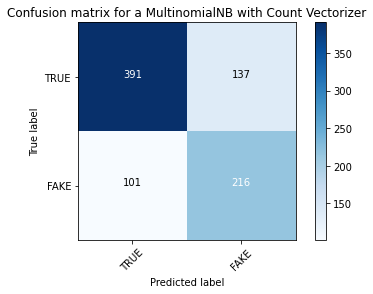

In [60]:
# Computations
import itertools

# Visualization
import matplotlib.pyplot as plt

# Let's re-run our fine-tuned model and plot the confusion matrix
nb_classifier = MultinomialNB(alpha = 0.15)
nb_classifier.fit(count_train, y_train)
pred_nb_count = nb_classifier.predict(count_test)
cm = metrics.confusion_matrix(y_test, pred_nb_count, labels=[0,1])

# Creating a function that outputs a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
plot_confusion_matrix(cm, classes=['TRUE','FAKE'], title ='Confusion matrix for a MultinomialNB with Count Vectorizer')

In [44]:
nb_classifier = MultinomialNB(alpha = 0.1)
nb_classifier.fit(tfidf_train, y_train)
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
acc_nb_tfidf = metrics.accuracy_score(y_test, pred_nb_tfidf)
print(acc_nb_tfidf)

0.8269742679680568


In [45]:
# tune the hyperparameter alpha for the naive bayes classifier
for alpha in np.arange(0,0.1,.01):
    nb_classifier_tune = MultinomialNB(alpha=alpha)
    nb_classifier_tune.fit(tfidf_train, y_train)
    pred_tune = nb_classifier_tune.predict(tfidf_test)
    score = metrics.accuracy_score(y_test, pred_tune)
    print("Alpha: {:.2f}  Score: {:.5f}".format(alpha, score))

Alpha: 0.00  Score: 0.82165
Alpha: 0.01  Score: 0.82343
Alpha: 0.02  Score: 0.82520
Alpha: 0.03  Score: 0.82697
Alpha: 0.04  Score: 0.83052
Alpha: 0.05  Score: 0.83141
Alpha: 0.06  Score: 0.82875
Alpha: 0.07  Score: 0.82964
Alpha: 0.08  Score: 0.83052
Alpha: 0.09  Score: 0.82786


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


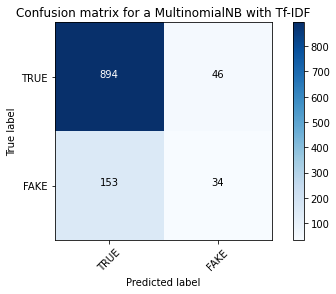

In [46]:
# Let's run the optimized model with best value of hyperparameter and check the confusion matrix
nb_classifier = MultinomialNB(alpha = 0.01)
nb_classifier.fit(tfidf_train, y_train)
pred_nb_tfidf = nb_classifier.predict(tfidf_test)
cm2 = metrics.confusion_matrix(y_test, pred_nb_tfidf, labels=[0,1])
plot_confusion_matrix(cm2, classes=['TRUE','FAKE'], title ='Confusion matrix for a MultinomialNB with Tf-IDF')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.7100591715976331


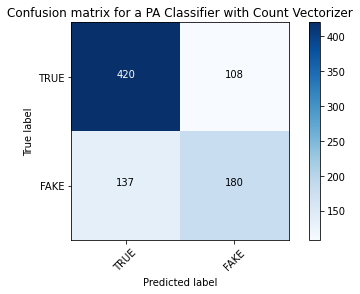

In [63]:
from sklearn.linear_model import  PassiveAggressiveClassifier
linear_classifier = PassiveAggressiveClassifier(max_iter=10)
linear_classifier.fit(count_train, y_train)
pred_linear_count = linear_classifier.predict(count_test)
acc_linear_count = metrics.accuracy_score(y_test, pred_linear_count)
print(acc_linear_count)
cm6 = metrics.confusion_matrix(y_test, pred_linear_count, labels=[0,1])
plot_confusion_matrix(cm6, classes=['TRUE','FAKE'], title ='Confusion matrix for a PA Classifier with Count Vectorizer')

In [64]:
print("Classification Report:")
print(classification_report(y_test,pred_linear_count))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       528
           1       0.62      0.57      0.60       317

    accuracy                           0.71       845
   macro avg       0.69      0.68      0.68       845
weighted avg       0.71      0.71      0.71       845

